## Global settings and imports

In [26]:
%load_ext autoreload
%autoreload 2

import sys
import torch
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from typing import Dict, List, Optional
import numpy as np
from pathlib import Path
import polars as pl
import matplotlib.pyplot as plt

from utils._constants import (
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_IMPRESSION_ID_COL,
    DEFAULT_SUBTITLE_COL,
    DEFAULT_LABELS_COL,
    DEFAULT_TITLE_COL,
    DEFAULT_USER_COL,
    DEFAULT_ARTICLE_PUBLISHED_TIMESTAMP_COL
)

from utils._behaviors import (
    create_binary_labels_column,
    sampling_strategy_wu2019,
    add_known_user_column,
    add_prediction_scores,
    truncate_history,
)
from evaluation import MetricEvaluator, AucScore, NdcgScore, MrrScore
from utils._articles import convert_text2encoding_with_transformers
from utils._polars import concat_str_columns, slice_join_dataframes
from utils._articles import create_article_id_to_value_mapping
from utils._nlp import get_transformers_word_embeddings, generate_embeddings_with_transformers
from utils._python import write_submission_file, rank_predictions_by_score
from models_pytorch.model_config import hparams_nrms

from models_pytorch.nrms import NRMSModel

from transformers import AutoModel, AutoTokenizer
from models_pytorch.dataloader import NRMSDataLoader



# Check Python version
print(f"Python version: {sys.version.split()[0]}")

# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Check GPU availability
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU device: {torch.cuda.get_device_name()}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python version: 3.12.1
PyTorch version: 2.5.1+cu121
CUDA available: True
Current GPU device: NVIDIA GeForce RTX 3070
Number of GPUs available: 1


## Prepare parameters

In [27]:
seed = 42
batch_size = 32

# Options: demo, small, large
MIND_type = 'demo'

## Looking at behaviours and history

## Download and load data

In [28]:
PATH = Path("./ebnerd_small")  # Base path for your data directory
print(PATH)


ebnerd_small


In [29]:
def ebnerd_from_path(path: Path, history_size: int = 30) -> pl.DataFrame:
    """
    Load ebnerd - function
    """
    df_history = (
        pl.scan_parquet(path.joinpath("history.parquet"))
        .select(DEFAULT_USER_COL, DEFAULT_HISTORY_ARTICLE_ID_COL)
        .pipe(
            truncate_history,
            column=DEFAULT_HISTORY_ARTICLE_ID_COL,
            history_size=history_size,
            padding_value=0,
            enable_warning=False,
        )
    )
    df_behaviors = (
        pl.scan_parquet(path.joinpath("behaviors.parquet"))
        .collect()
        .pipe(
            slice_join_dataframes,
            df2=df_history.collect(),
            on=DEFAULT_USER_COL,
            how="left",
        )
    )
    return df_behaviors

COLUMNS = [
    DEFAULT_USER_COL,
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_IMPRESSION_ID_COL,
]
HISTORY_SIZE = 10 # TODO: History size. 
FRACTION = 0.001

df_train = (
    ebnerd_from_path(PATH.joinpath("train"), history_size=HISTORY_SIZE)
    .select(COLUMNS)
    .pipe(
        sampling_strategy_wu2019,
        npratio=4,
        shuffle=True,
        with_replacement=True,
        seed=123,
    )
    .pipe(create_binary_labels_column)
    .sample(fraction=FRACTION)
)
# =>
df_validation = (
    ebnerd_from_path(PATH.joinpath("validation"), history_size=HISTORY_SIZE)
    .select(COLUMNS)
    .pipe(create_binary_labels_column)
    .sample(fraction=FRACTION)
)
df_train.head(2)

shape: (2, 6)
┌─────────┬───────────────────┬───────────────────┬──────────────────┬───────────────┬─────────────┐
│ user_id ┆ article_id_fixed  ┆ article_ids_invie ┆ article_ids_clic ┆ impression_id ┆ labels      │
│ ---     ┆ ---               ┆ w                 ┆ ked              ┆ ---           ┆ ---         │
│ u32     ┆ list[i32]         ┆ ---               ┆ ---              ┆ u32           ┆ list[i8]    │
│         ┆                   ┆ list[i64]         ┆ list[i64]        ┆               ┆             │
╞═════════╪═══════════════════╪═══════════════════╪══════════════════╪═══════════════╪═════════════╡
│ 1485824 ┆ [9769828,         ┆ [9775484,         ┆ [9775484]        ┆ 95929960      ┆ [1, 0, … 0] │
│         ┆ 9769514, …        ┆ 9775419, …        ┆                  ┆               ┆             │
│         ┆ 9728166]          ┆ 7306652]          ┆                  ┆               ┆             │
│ 2555592 ┆ [9770989,         ┆ [9771787,         ┆ [9771916]        ┆ 281616279     ┆ [0, 1, … 0] │
│         ┆ 9770882, …        ┆ 9771916, …        ┆                  ┆               ┆             │
│         ┆ 9769622]          ┆ 9771948]          ┆                  ┆               ┆             │
└─────────┴───────────────────┴───────────────────┴──────────────────┴───────────────┴─────────────┘

In [30]:
import polars as pl

# Function to find the maximum length of arrays in a column
def find_max_length(df, column):
    max_length = 0
    for row in df[column]:
        max_length = max(max_length, len(row))
    return max_length

# Find the longest inview article length in df_train
max_inview_length_train = find_max_length(df_train, DEFAULT_INVIEW_ARTICLES_COL)

# Find the longest inview article length in df_validation
max_inview_length_validation = find_max_length(df_validation, DEFAULT_INVIEW_ARTICLES_COL)

print(f"Longest inview article length in df_train: {max_inview_length_train}")
print(f"Longest inview article length in df_validation: {max_inview_length_validation}")

max_history_length_train = find_max_length(df_train, DEFAULT_HISTORY_ARTICLE_ID_COL)
max_history_length_validation = find_max_length(df_validation, DEFAULT_HISTORY_ARTICLE_ID_COL)

print(f"Longest history length in df_train: {max_history_length_train}")
print(f"Longest history length in df_validation: {max_history_length_validation}")

Longest inview article length in df_train: 5
Longest inview article length in df_validation: 75
Longest history length in df_train: 10
Longest history length in df_validation: 10


In [31]:
import polars as pl

# Function to filter rows with exactly one clicked article
def filter_rows_with_one_clicked_article(df, clicked_articles_col):
    # Manually filter rows where the array has exactly one element
    filtered_rows = []
    for row in df.iter_rows(named=True):
        if len(row[clicked_articles_col]) == 1:
            filtered_rows.append(row)
    return pl.DataFrame(filtered_rows)


# Filter rows in df_train and df_validation
df_train = filter_rows_with_one_clicked_article(df_train, DEFAULT_CLICKED_ARTICLES_COL)
df_validation = filter_rows_with_one_clicked_article(df_validation, DEFAULT_CLICKED_ARTICLES_COL)

# Print the results
print(f"Number of rows with exactly one clicked article in df_train: {df_train.shape[0]}")
print(f"Number of rows with exactly one clicked article in df_validation: {df_validation.shape[0]}")


Number of rows with exactly one clicked article in df_train: 234
Number of rows with exactly one clicked article in df_validation: 243


In [32]:
df_articles = pl.read_parquet(PATH.joinpath("articles.parquet"))
df_articles.head(10)

shape: (10, 21)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ article_i ┆ title     ┆ subtitle  ┆ last_modi ┆ … ┆ total_pag ┆ total_rea ┆ sentiment ┆ sentimen │
│ d         ┆ ---       ┆ ---       ┆ fied_time ┆   ┆ eviews    ┆ d_time    ┆ _score    ┆ t_label  │
│ ---       ┆ str       ┆ str       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ i32       ┆           ┆           ┆ datetime[ ┆   ┆ i32       ┆ f32       ┆ f32       ┆ str      │
│           ┆           ┆           ┆ μs]       ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 3001353   ┆ Natascha  ┆ Politiet  ┆ 2023-06-2 ┆ … ┆ null      ┆ null      ┆ 0.9955    ┆ Negative │
│           ┆ var ikke  ┆ frygter   ┆ 9         ┆   ┆           ┆           ┆           ┆          │
│           ┆ den       ┆ nu, at    ┆ 06:20:33  ┆   ┆           ┆           ┆           ┆          │
│           ┆ første    ┆ Natasc…   ┆           ┆   ┆           ┆           ┆           ┆          │
│ 3003065   ┆ Kun Star  ┆ Biografgæ ┆ 2023-06-2 ┆ … ┆ null      ┆ null      ┆ 0.846     ┆ Positive │
│           ┆ Wars      ┆ ngerne    ┆ 9         ┆   ┆           ┆           ┆           ┆          │
│           ┆ tjente    ┆ strømmer  ┆ 06:20:35  ┆   ┆           ┆           ┆           ┆          │
│           ┆ mere      ┆ ind f…    ┆           ┆   ┆           ┆           ┆           ┆          │
│ 3012771   ┆ Morten    ┆ FODBOLD:  ┆ 2023-06-2 ┆ … ┆ null      ┆ null      ┆ 0.8241    ┆ Negative │
│           ┆ Bruun     ┆ Morten    ┆ 9         ┆   ┆           ┆           ┆           ┆          │
│           ┆ fyret i   ┆ Bruun     ┆ 06:20:39  ┆   ┆           ┆           ┆           ┆          │
│           ┆ Sønderjys ┆ fyret me… ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ …         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 3023463   ┆ Luderne   ┆ I landets ┆ 2023-06-2 ┆ … ┆ null      ┆ null      ┆ 0.7053    ┆ Neutral  │
│           ┆ flytter   ┆ tyndest   ┆ 9         ┆   ┆           ┆           ┆           ┆          │
│           ┆ på landet ┆ befolkede ┆ 06:20:43  ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ om…       ┆           ┆   ┆           ┆           ┆           ┆          │
│ 3032577   ┆ Cybersex: ┆ En        ┆ 2023-06-2 ┆ … ┆ null      ┆ null      ┆ 0.9307    ┆ Neutral  │
│           ┆ Hvornår   ┆ flirtende ┆ 9         ┆   ┆           ┆           ┆           ┆          │
│           ┆ er man    ┆ sms til   ┆ 06:20:46  ┆   ┆           ┆           ┆           ┆          │
│           ┆ utro?     ┆ den       ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ flott…    ┆           ┆   ┆           ┆           ┆           ┆          │
│ 3033563   ┆ Kniven    ┆ I         ┆ 2023-06-2 ┆ … ┆ null      ┆ null      ┆ 0.9371    ┆ Neutral  │
│           ┆ for strub ┆ aftenens  ┆ 9         ┆   ┆           ┆           ┆           ┆          │
│           ┆ en-vært   ┆ udgave af ┆ 06:20:47  ┆   ┆           ┆           ┆           ┆          │
│           ┆ får se…   ┆ 'Med      ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ kniv…     ┆           ┆   ┆           ┆           ┆           ┆          │
│ 3034608   ┆ Willy     ┆ Den       ┆ 2023-06-2 ┆ … ┆ null      ┆ null      ┆ 0.9971    ┆ Negative │
│           ┆ Strube    ┆ tidligere ┆ 9         ┆   ┆           ┆           ┆           ┆          │
│           ┆ har       ┆ SiD-chef  ┆ 06:20:49  ┆   ┆           ┆           ┆           ┆          │
│           ┆ begået    ┆ tog sit…  ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ selvmo…   ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 3034849   ┆ Venner    ┆ VK-REGERI ┆ 2023-06

In [33]:
from transformers import AutoConfig, AutoTokenizer, AutoModel


In [34]:
# TRANSFORMER_MODEL_NAME = "FacebookAI/xlm-roberta-base"
TRANSFORMER_MODEL_NAME = "prajjwal1/bert-tiny"
#TRANSFORMER_MODEL_NAME = "distilbert-base-multilingual-cased"

#TRANSFORMER_MODEL_NAME = "pbelcak/UltraFastBERT-1x11-long"

TEXT_COLUMNS_TO_USE = [DEFAULT_SUBTITLE_COL, DEFAULT_TITLE_COL, DEFAULT_ARTICLE_PUBLISHED_TIMESTAMP_COL]
MAX_TITLE_LENGTH = 30

# LOAD HUGGINGFACE:
transformer_model = AutoModel.from_pretrained(TRANSFORMER_MODEL_NAME)
transformer_tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)

# We'll init the word embeddings using the
word2vec_embedding = get_transformers_word_embeddings(transformer_model)
#
df_articles, cat_cal = concat_str_columns(df_articles, columns=TEXT_COLUMNS_TO_USE)
df_articles, token_col_title = convert_text2encoding_with_transformers(
    df_articles, transformer_tokenizer, cat_cal, max_length=MAX_TITLE_LENGTH
)
# =>
article_mapping = create_article_id_to_value_mapping(
    df=df_articles, value_col=token_col_title
)

In [35]:
# # 1. Create custom tokenizer and config
# from transformers import AutoConfig, AutoTokenizer, AutoModel
# from torch.nn.utils.prune import l1_unstructured

# VOCAB_SIZE = 10000  # Reduced from 250k
# EMBEDDING_DIM = 128 # Reduced from 768

# # 2. Load with smaller config
# config = AutoConfig.from_pretrained(TRANSFORMER_MODEL_NAME)
# config.vocab_size = VOCAB_SIZE
# config.hidden_size = EMBEDDING_DIM
# config.num_attention_heads = 4
# config.intermediate_size = EMBEDDING_DIM * 4

# # 3. Initialize tokenizer with smaller vocab
# transformer_tokenizer = AutoTokenizer.from_pretrained(
#     TRANSFORMER_MODEL_NAME,
#     model_max_length=128,
#     vocab_size=VOCAB_SIZE
# )

# # 4. Load model with reduced config and ignore mismatched sizes
# transformer_model = AutoModel.from_pretrained(
#     TRANSFORMER_MODEL_NAME,
#     config=config,
#     ignore_mismatched_sizes=True  # Ignore size mismatches
# )

# # 5. Apply pruning to embedding layer (optional)
# l1_unstructured(
#     transformer_model.embeddings.word_embeddings,
#     name='weight',
#     amount=0.3  # Prune 30% of weights
# )

# word2vec_embedding = get_transformers_word_embeddings(transformer_model)

In [36]:
df_articles, cat_cal = concat_str_columns(df_articles, columns=TEXT_COLUMNS_TO_USE)
df_articles, token_col_title = convert_text2encoding_with_transformers(
    df_articles, transformer_tokenizer, cat_cal, max_length=MAX_TITLE_LENGTH
)
# =>
article_mapping = create_article_id_to_value_mapping(
    df=df_articles, value_col=token_col_title
)

In [37]:
print(f"Number of articles: {len(article_mapping)}")
print(f"article_mapping: {article_mapping}")

Number of articles: 20738
article_mapping: {3001353: shape: (30,)
Series: '' [i64]
[
	14955
	25090
	3388
	14744
	13512
	…
	6643
	3520
	28656
	18377
	14728
], 3003065: shape: (30,)
Series: '' [i64]
[
	16012
	17643
	2546
	2290
	29667
	…
	2140
	2615
	18168
	2019
	10199
], 3012771: shape: (30,)
Series: '' [i64]
[
	1042
	7716
	27495
	1024
	22294
	…
	3653
	2015
	25312
	14437
	11795
], 3023463: shape: (30,)
Series: '' [i64]
[
	1045
	2455
	8454
	5939
	13629
	…
	8525
	6850
	2063
	23310
	2063
], 3032577: shape: (30,)
Series: '' [i64]
[
	4372
	27978
	10497
	2063
	22434
	…
	16415
	11927
	2063
	6643
	4372
], 3033563: shape: (30,)
Series: '' [i64]
[
	1045
	16638
	8625
	3619
	20904
	…
	2140
	2358
	16415
	12096
	2063
], 3034608: shape: (30,)
Series: '' [i64]
[
	7939
	14841
	19422
	17071
	2063
	…
	16363
	2102
	21358
	6904
	25708
], 3034849: shape: (30,)
Series: '' [i64]
[
	1058
	2243
	1011
	19723
	7999
	…
	2692
	0
	0
	0
	0
], 3035648: shape: (30,)
Series: '' [i64]
[
	13012
	2638
	8709
	5054
	1044
	…
	2

In [38]:
print(f"word embeddings shape: {word2vec_embedding.shape}")

word embeddings shape: (30522, 128)


# Init dataloaders



In [39]:


train_dataset = NRMSDataLoader(
    behaviors=df_train,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column=DEFAULT_HISTORY_ARTICLE_ID_COL,
    eval_mode=False,
    batch_size=2*batch_size,
)
val_dataset = NRMSDataLoader(
    behaviors=df_validation,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column=DEFAULT_HISTORY_ARTICLE_ID_COL,
    eval_mode=True,
    batch_size=batch_size,
)

In [40]:
for idx in range(5):
    sample = train_dataset[idx]
    print(f"Sample {idx}:")
    print(f"his_input_title shape: {sample[0][0].shape}")
    print(f"pred_input_title shape: {sample[0][1].shape} {sample[0][1].sum()}")
    print(f"Targets shape: {sample[1].shape} , {sample[1].dtype} {sample[1].sum()}")


Sample 0:
his_input_title shape: torch.Size([10, 30])
pred_input_title shape: torch.Size([5, 30]) 1249935.0
Targets shape: torch.Size([5]) , torch.float32 1.0
Sample 1:
his_input_title shape: torch.Size([10, 30])
pred_input_title shape: torch.Size([5, 30]) 1323193.0
Targets shape: torch.Size([5]) , torch.float32 1.0
Sample 2:
his_input_title shape: torch.Size([10, 30])
pred_input_title shape: torch.Size([5, 30]) 1233455.0
Targets shape: torch.Size([5]) , torch.float32 1.0
Sample 3:
his_input_title shape: torch.Size([10, 30])
pred_input_title shape: torch.Size([5, 30]) 1354933.0
Targets shape: torch.Size([5]) , torch.float32 1.0
Sample 4:
his_input_title shape: torch.Size([10, 30])
pred_input_title shape: torch.Size([5, 30]) 1471013.0
Targets shape: torch.Size([5]) , torch.float32 1.0


In [41]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    try:
        his_input_titles = [item[0][0] for item in batch]  # List of tensors
        pred_input_titles = [item[0][1] for item in batch]
        batch_ys = [item[1] for item in batch]

        # Check for empty sequences
        for idx, seq in enumerate(his_input_titles):
            if seq.size(0) == 0:
                print(f"Empty his_input_title at batch index {idx}")
        for idx, seq in enumerate(pred_input_titles):
            if seq.size(0) == 0:
                print(f"Empty pred_input_title at batch index {idx}")
        for idx, seq in enumerate(batch_ys):
            if seq.size(0) == 0:
                print(f"Empty batch_y at batch index {idx}")

        # Remove empty sequences or handle them appropriately
        # For now, let's filter them out
        valid_indices = [i for i, seq in enumerate(his_input_titles) if seq.size(0) > 0 and pred_input_titles[i].size(0) > 0 and batch_ys[i].size(0) > 0]
        if not valid_indices:
            raise ValueError("All sequences in the batch are empty.")

        his_input_titles = [his_input_titles[i] for i in valid_indices]
        pred_input_titles = [pred_input_titles[i] for i in valid_indices]
        batch_ys = [batch_ys[i] for i in valid_indices]

        # Pad sequences
        his_input_titles_padded = pad_sequence(his_input_titles, batch_first=True, padding_value=0)
        pred_input_titles_padded = pad_sequence(pred_input_titles, batch_first=True, padding_value=0)
        batch_ys_padded = pad_sequence(batch_ys, batch_first=True, padding_value=0)

        return (his_input_titles_padded, pred_input_titles_padded), batch_ys_padded
    except Exception as e:
        print(f"Error in collate_fn: {e}")
        raise

In [42]:
# Wrap the dataset with DataLoader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,    # Set your desired batch size
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn

)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,    # Set your desired batch size
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

## Create hyper-parameters

In [43]:
for batch_idx, (inputs, targets) in enumerate(train_dataloader):
    his_input_title, pred_input_title = inputs
    print(f"Batch {batch_idx + 1}")
    print(f"his_input_title shape: {his_input_title.shape}, dtype: {his_input_title.dtype}")
    print(f"pred_input_title shape: {pred_input_title.shape}, dtype: {pred_input_title.dtype}")
    print(f"Targets shape: {targets.shape}, dtype: {targets.dtype}")
    break

Batch 1
his_input_title shape: torch.Size([32, 10, 30]), dtype: torch.float32
pred_input_title shape: torch.Size([32, 5, 30]), dtype: torch.float32
Targets shape: torch.Size([32, 5]), dtype: torch.float32


In [44]:
# hparams_nrms.attention_hidden_dim = 10
# hparams_nrms.head_num = 2
# hparams_nrms.head_dim = 2
# hparams_nrms.hidden_dim = 5
# hparams_nrms.news_output_dim = 100

print(hparams_nrms.__dict__)

{'__module__': 'models_pytorch.model_config', '__annotations__': {'title_size': <class 'int'>, 'history_size': <class 'int'>, 'embedding_dim': <class 'int'>, 'word_emb_dim': <class 'int'>, 'vocab_size': <class 'int'>, 'head_num': <class 'int'>, 'head_dim': <class 'int'>, 'attention_hidden_dim': <class 'int'>, 'optimizer': <class 'str'>, 'loss': <class 'str'>, 'dropout': <class 'float'>, 'learning_rate': <class 'float'>}, 'title_size': 16, 'history_size': 5, 'embedding_dim': 32, 'word_emb_dim': 8, 'vocab_size': 10000, 'head_num': 2, 'head_dim': 4, 'attention_hidden_dim': 4, 'hidden_dim': 4, 'optimizer': 'adam', 'loss': 'cross_entropy_loss', 'dropout': 0.3, 'learning_rate': 0.001, 'news_output_dim': 4, '__dict__': <attribute '__dict__' of 'hparams_nrms' objects>, '__weakref__': <attribute '__weakref__' of 'hparams_nrms' objects>, '__doc__': None}


## Train the NRMS model

In [45]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# Define paths
MODEL_NAME = "NRMS"
LOG_DIR = os.path.join("downloads", "runs", MODEL_NAME)
MODEL_WEIGHTS = os.path.join("downloads", "data", "state_dict", MODEL_NAME, "weights.pth")

# Create directories if they don't exist
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(os.path.dirname(MODEL_WEIGHTS), exist_ok=True)

# Define EarlyStopping class
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=2, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            if self.verbose:
                print(f"Initial validation loss: {self.best_loss:.6f}")
        elif val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.verbose:
                print(f"Validation loss decreased to {self.best_loss:.6f}. Resetting counter.")
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement in validation loss for {self.counter} epochs.")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered.")

# Define ModelCheckpoint class
class ModelCheckpoint:
    """Saves the model after every epoch if it has the best performance so far."""
    def __init__(self, filepath, verbose=False, save_best_only=True):
        """
        Args:
            filepath (str): Path to save the model checkpoint.
            verbose (bool): If True, prints a message when the model is saved.
            save_best_only (bool): If True, saves only when the model is better than before.
        """
        self.filepath = filepath
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.best_loss = None

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss:
            self.best_loss = val_loss
            self.save_checkpoint(model)

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.filepath)
        if self.verbose:
            print(f"Model saved to {self.filepath}")

# Initialize TensorBoard SummaryWriter
writer = SummaryWriter(log_dir=LOG_DIR)

# Initialize callbacks
early_stopping = EarlyStopping(patience=2, verbose=True)
model_checkpoint = ModelCheckpoint(filepath=MODEL_WEIGHTS, verbose=True, save_best_only=True)


# Initialize your model
# Ensure that NRMSModel is a PyTorch nn.Module

# CUDA checks
#print(f"CUDA Available: {torch.cuda.is_available()}")
#print(f"Current Device: {torch.cuda.current_device()}")
#print(f"Device Name: {torch.cuda.get_device_name()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
model = NRMSModel(
    hparams=hparams_nrms.__dict__,
    word2vec_embedding=word2vec_embedding,
    vocab_size=1000,
    word_emb_dim=8,
    seed=seed,
    device=device
)
print(f"Model device: {next(model.parameters()).device}")

Using device: cuda
Model device: cuda:0


In [46]:
def print_prediction_details(outputs, targets, k=5):
    """Print detailed prediction information for the first k samples"""
    # Get predicted class (highest score)
    _, predicted = torch.max(outputs.data, 1)
    
    # Calculate accuracy for this batch
    correct = (predicted == targets).sum().item()
    total = targets.size(0)
    accuracy = 100 * correct / total
    
    # Print details for k samples
    for i in range(min(k, len(targets))):
        print(f"\nSample {i}:")
        print(f"Predicted probabilities: {torch.softmax(outputs[i], dim=0)}")
        print(f"Predicted class: {predicted[i]}, True class: {targets[i]}")
        print(f"Correct: {predicted[i] == targets[i]}")
    
    return accuracy

In [47]:
# 1. Print model architecture
print(model)

# 2. Print specific layer sizes
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()}")

# 3. Get total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

# 4. Print layer by layer with shapes
def print_model_structure(model):
    print("\nDetailed Model Structure:")
    for name, module in model.named_children():
        print(f"\nLayer: {name}")
        print(f"Type: {type(module).__name__}")
        if hasattr(module, 'weight'):
            print(f"Shape: {module.weight.shape}")

NRMSModel(
  (newsencoder): NewsEncoder(
    (embedding): Embedding(30522, 128)
    (fc1): Linear(in_features=128, out_features=4, bias=True)
    (relu): ReLU()
    (fc2): Linear(in_features=4, out_features=4, bias=True)
  )
  (userencoder): UserEncoder(
    (titleencoder): NewsEncoder(
      (embedding): Embedding(30522, 128)
      (fc1): Linear(in_features=128, out_features=4, bias=True)
      (relu): ReLU()
      (fc2): Linear(in_features=4, out_features=4, bias=True)
    )
    (self_attention): SelfAttention()
    (attention_layer): AttLayer2(
      (q): Linear(in_features=4, out_features=1, bias=False)
    )
    (user_projection): Linear(in_features=4, out_features=4, bias=True)
  )
)
Layer: newsencoder.embedding.weight | Size: torch.Size([30522, 128])
Layer: newsencoder.fc1.weight | Size: torch.Size([4, 128])
Layer: newsencoder.fc1.bias | Size: torch.Size([4])
Layer: newsencoder.fc2.weight | Size: torch.Size([4, 4])
Layer: newsencoder.fc2.bias | Size: torch.Size([4])
Layer: usere

In [48]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Parameters: {param.numel()}")

Layer: newsencoder.embedding.weight | Size: torch.Size([30522, 128]) | Parameters: 3906816
Layer: newsencoder.fc1.weight | Size: torch.Size([4, 128]) | Parameters: 512
Layer: newsencoder.fc1.bias | Size: torch.Size([4]) | Parameters: 4
Layer: newsencoder.fc2.weight | Size: torch.Size([4, 4]) | Parameters: 16
Layer: newsencoder.fc2.bias | Size: torch.Size([4]) | Parameters: 4
Layer: userencoder.attention_layer.b | Size: torch.Size([4]) | Parameters: 4
Layer: userencoder.attention_layer.q.weight | Size: torch.Size([1, 4]) | Parameters: 4
Layer: userencoder.user_projection.weight | Size: torch.Size([4, 4]) | Parameters: 16
Layer: userencoder.user_projection.bias | Size: torch.Size([4]) | Parameters: 4


In [49]:
from tqdm import tqdm
import torch
import torch.optim as optim

# Define loss function and optimizer
criterion = model.get_loss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
NUM_EPOCHS = 200
train_losses, val_losses = [], []

# Epoch progress bar
epoch_pbar = tqdm(range(1, NUM_EPOCHS + 1), desc="Training Progress", dynamic_ncols=True)
for epoch in epoch_pbar:
    # Training phase
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    for inputs, targets in train_dataloader:
        # Prepare data
        inputs = [inp.to(device) for inp in inputs]
        targets = targets.to(device)
        # Get positive labels
        positive_indices = (targets == 1).nonzero(as_tuple=False)
        targets = positive_indices[:, 1].long()
        # Forward and backward passes
        optimizer.zero_grad()
        outputs = model(*inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        # Calculate metrics
        _, predicted = torch.max(outputs.data, 1)
        accuracy = 100 * (predicted == targets).sum().item() / targets.size(0)
        # Update running statistics
        running_loss += loss.item()
        running_accuracy += accuracy

    avg_train_loss = running_loss / len(train_dataloader)
    avg_train_accuracy = running_accuracy / len(train_dataloader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():
        for inputs, targets in val_dataloader:
            inputs = [inp.to(device) for inp in inputs]
            targets = targets.to(device)
            positive_indices = (targets == 1).nonzero(as_tuple=False)
            targets = positive_indices[:, 1].long()
            outputs = model(*inputs)
            loss = criterion(outputs, targets)
            _, predicted = torch.max(outputs.data, 1)
            accuracy = 100 * (predicted == targets).sum().item() / targets.size(0)
            val_loss += loss.item()
            val_accuracy += accuracy

    avg_val_loss = val_loss / len(val_dataloader)
    avg_val_accuracy = val_accuracy / len(val_dataloader)

    # Update tensorboard
    writer.add_scalar('Loss/Train', avg_train_loss, epoch)
    writer.add_scalar('Loss/Validation', avg_val_loss, epoch)
    writer.add_scalar('Accuracy/Train', avg_train_accuracy, epoch)
    writer.add_scalar('Accuracy/Validation', avg_val_accuracy, epoch)

    # Update epoch progress bar with metrics
    epoch_pbar.set_postfix({
        'train_loss': f'{avg_train_loss:.4f}',
        'val_loss': f'{avg_val_loss:.4f}',
        'train_acc': f'{avg_train_accuracy:.2f}%',
        'val_acc': f'{avg_val_accuracy:.2f}%'
    })

    # Save checkpoint
    if epoch % 10 == 0:
        model_checkpoint(model, avg_val_loss)

writer.close()
# 305s / it. 
# 304.55s/it

Training Progress:   5%|▌         | 10/200 [01:25<27:00,  8.53s/it, train_loss=1.5331, val_loss=3.7969, train_acc=72.50%, val_acc=0.00%]

Model saved to downloads\data\state_dict\NRMS\weights.pth


Training Progress: 100%|██████████| 200/200 [28:40<00:00,  8.60s/it, train_loss=0.0795, val_loss=21.4883, train_acc=96.48%, val_acc=0.66%]


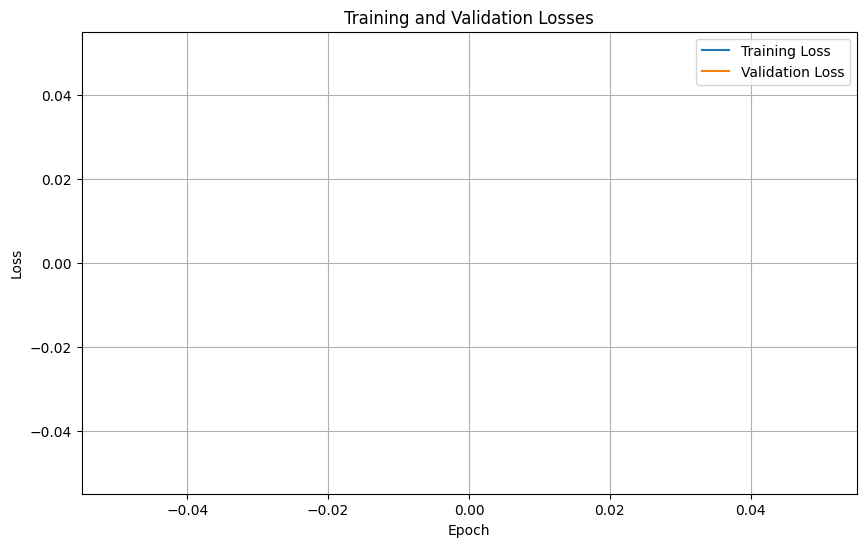


Training Summary:


IndexError: list index out of range

In [51]:

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

# Print final statistics
print("\nTraining Summary:")
print(f"Initial Training Loss: {train_losses[0]:.4f}")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Best Training Loss: {min(train_losses):.4f}")
print(f"\nInitial Validation Loss: {val_losses[0]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Best Validation Loss: {min(val_losses):.4f}")

## Evaluate the model

In [52]:
with torch.no_grad():
    pred_validation = model.predict(val_dataloader)

# Add predictions to dataframe
df_validation = add_prediction_scores(df_validation, pred_validation).pipe(
    add_known_user_column, known_users=df_train[DEFAULT_USER_COL]
)

# Compute metrics
metrics = MetricEvaluator(
    labels=df_validation["labels"].to_list(),
    predictions=df_validation["scores"].to_list(),
    metric_functions=[AucScore(), MrrScore(), NdcgScore(k=5), NdcgScore(k=10)],
)
results = metrics.evaluate()
print("\nMetrics:", results.evaluations)


Metrics: {'auc': 0.5044445863586056, 'mrr': 0.306999622813075, 'ndcg@5': 0.3390402152271695, 'ndcg@10': 0.4227493649879059}


## Output Prediction File

## References

https://github.com/recommenders-team/recommenders/blob/main/examples/00_quick_start/nrms_MIND.ipynb